In [1]:
import time
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

params = {
    # 'font.family': 'Inter',
    'font.family': 'sans-serif',
    'legend.fontsize': 'x-small',
    'axes.labelsize': 'x-small',
    'axes.titlesize': 'x-small',
    'xtick.labelsize': 'x-small',
    'ytick.labelsize': 'x-small',
    # 'figure.figsize': (3.0, 1.7),
}
plt.rcParams.update(params)
plt.clf()

log_headers = ["timesteps", "start_time", "action", "latency", "file_path", "num_query"]

<Figure size 640x480 with 0 Axes>

In [10]:
def parse_timestamp(timestamp_str):
    # 2024-04-12 14:45:40.00857
    # to datetime object
    return pd.to_datetime(timestamp_str, format='%Y-%m-%d %H:%M:%S.%f')

def parse_func_name(func_name_str):
    # Func:'load_index' => "load_index"
    str_l = func_name_str.split(":")
    if "completed" in func_name_str:
        return func_name_str
    return str_l[-1][:]

def parse_latency(time_str):
    return float(time_str[:-1])

def create_gantt_chart(load_index_hbars, search_index_hbars, figsize=(4, 1.2), ax=None, vline=True):
    return_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        return_ax = True

    bar_width = 0.5
    bar_gap = 0.0
    # [(x, length), ()], (y, bar_width)
    ax.broken_barh(load_index_hbars[:], (1, bar_width), facecolors =('darkorange'))
    ax.broken_barh(search_index_hbars[:], (1+bar_width+bar_gap, bar_width), facecolors =('green'))

    ax.set_yticks([1+bar_width/2, 1+bar_width+bar_gap+bar_width/2], ['load', 'search'])
    # ax.grid(True, alpha=0.5)

    if vline:
        last_x = search_index_hbars[-1][0]+search_index_hbars[-1][1]
        ax.axvline(x=last_x, color='black', linestyle='--', alpha=1)

    if return_ax:
        return fig, ax
    return ax

# Index async

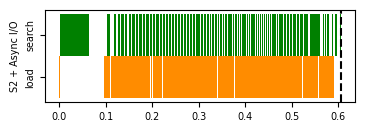

In [13]:
# read log file without header
fpath = '../logs/keep/asyncV5/st_index_async_1_batch.log'
df = pd.read_csv(fpath, header=None)

# change column name
df.columns = log_headers

# df['fine_timesteps'] = df['fine_timesteps'].map(parse_timestamp)

df["action"] = df["action"].map(parse_func_name)
df["latency"] = df["latency"].map(parse_latency)
df['start_time'] = df['start_time'] - df['start_time'][0]

load_index_hbars3 = []
search_index_hbars3 = []

for i, row in df[df["action"] == "load_index"].iterrows():
    load_index_hbars3.append((row["start_time"], row["latency"]))

for i, row in df[df["action"] == "query_index"].iterrows():
    search_index_hbars3.append((row["start_time"], row["latency"]))

fig, ax = create_gantt_chart(load_index_hbars3, search_index_hbars3, ax=None)
# ax.set_xlabel("Time (s)")
ax.set_ylabel("S2 + Async I/O")

# rotate y-axis labels, center them
plt.yticks(rotation=90, va='center')

# fig.tight_layout()
plt.savefig("plots/st_index_async_1_batch.pdf", bbox_inches="tight")
plt.show()

# index 

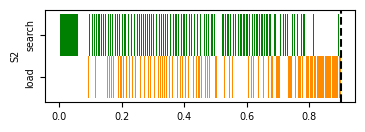

In [14]:
# read log file without header
df = pd.read_csv('../logs/keep/asyncV5/st_index_1_batch.log', header=None)

# change column name
df.columns = log_headers

# df['fine_timesteps'] = df['fine_timesteps'].map(parse_timestamp)

df["action"] = df["action"].map(parse_func_name)
df["latency"] = df["latency"].map(parse_latency)

# make a new column for the cumulative sum of the latency
df["cumulative_latency"] = df["latency"].cumsum()
df["start_time_old"] = df["cumulative_latency"] - df["latency"]
df['start_time'] = df['start_time'] - df['start_time'][0]
# df['start_time'] = df['start_time'].dt.total_seconds()

load_index_hbars = []
search_index_hbars = []

for i, row in df[df["action"] == "load_index"].iterrows():
    load_index_hbars.append((row["start_time"], row["latency"]))

for i, row in df[df["action"] == "query_index"].iterrows():
    search_index_hbars.append((row["start_time"], row["latency"]))

fig, ax = create_gantt_chart(load_index_hbars, search_index_hbars, ax=None)
ax.set_ylabel("S2")
plt.yticks(rotation=90, va='center')
# fig.tight_layout()
plt.savefig("plots/st_index_1_batch.pdf", bbox_inches="tight")
plt.show()

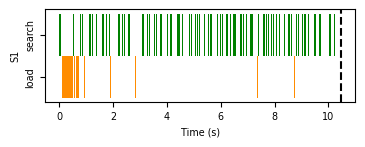

In [23]:
# read log file without header
df = pd.read_csv('../logs/keep/asyncV5/st_query_1_batch.log', header=None)

# change column name
df.columns = log_headers

# df['fine_timesteps'] = df['fine_timesteps'].map(parse_timestamp)

df["action"] = df["action"].map(parse_func_name)
df["latency"] = df["latency"].map(parse_latency)

# make a new column for the cumulative sum of the latency
df["cumulative_latency"] = df["latency"].cumsum()
df["start_time_old"] = df["cumulative_latency"] - df["latency"]
df['start_time'] = df['start_time'] - df['start_time'][0]
# df['start_time'] = df['start_time'].dt.total_seconds()

load_index_hbars2 = []
search_index_hbars2 = []

for i, row in df[df["action"] == "load_index"].iterrows():
    load_index_hbars2.append((row["start_time"], row["latency"]))

for i, row in df[df["action"] == "query_index"].iterrows():
    search_index_hbars2.append((row["start_time"], row["latency"]))

fig, ax = create_gantt_chart(load_index_hbars2, search_index_hbars2, ax=None)
ax.set_ylabel("S1")
ax.set_xlabel("Time (s)")
plt.yticks(rotation=90, va='center')
# fig.tight_layout()
plt.savefig("plots/st_query_1_batch.pdf", bbox_inches="tight")
plt.show()

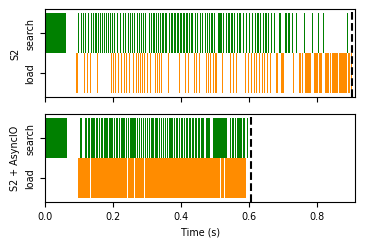

In [26]:
# make subplot 2 columns
fig, ax = plt.subplots(2, 1, figsize=(4, 2.5))
ax[0] = create_gantt_chart(load_index_hbars, search_index_hbars, ax=ax[0])
ax[1] = create_gantt_chart(load_index_hbars3, search_index_hbars3, ax=ax[1])

# rotate y-axis labels, center them
plt.setp(ax[0].get_yticklabels(), rotation=90, va='center')
plt.setp(ax[1].get_yticklabels(), rotation=90, va='center')


# remove xticks from the first subplot
plt.setp(ax[0].get_xticklabels(), visible=False)

# set xlim for the second subplot
max_x = max(search_index_hbars[-1][0]+search_index_hbars[-1][1], search_index_hbars3[-1][0]+search_index_hbars3[-1][1])
ax[1].set_xlim(-0., max_x*1.01)
ax[0].set_xlim(-0., max_x*1.01)

# set xlabel for the second subplot
ax[0].set_ylabel("S2")
ax[1].set_ylabel("S2 + AsyncIO")
ax[1].set_xlabel("Time (s)")

# fig.tight_layout()
fig.savefig("plots/index_index_async.pdf", bbox_inches="tight")
fig.show()

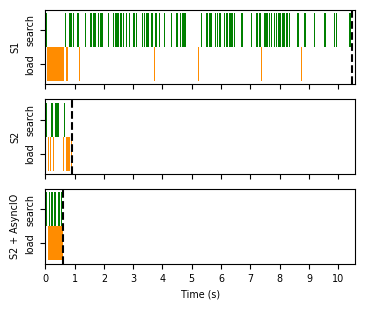

In [27]:
# make subplot 2 columns
fig, ax = plt.subplots(3, 1, figsize=(4, 3.3))

ax[0] = create_gantt_chart(load_index_hbars2, search_index_hbars2, ax=ax[0])
ax[1] = create_gantt_chart(load_index_hbars, search_index_hbars, ax=ax[1])
ax[2] = create_gantt_chart(load_index_hbars3, search_index_hbars3, ax=ax[2])


# remove xticks from the first subplot
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)

# set xlim for the second subplot
max_x = max(search_index_hbars[-1][0]+search_index_hbars[-1][1], search_index_hbars2[-1][0]+search_index_hbars2[-1][1])

ax[0].set_xlim(-0., max_x*1.01)
ax[1].set_xlim(-0., max_x*1.01)
ax[2].set_xlim(-0., max_x*1.01)

# set xlabel for the second subplot
ax[0].set_ylabel("S1")
ax[1].set_ylabel("S2")
ax[2].set_ylabel("S2 + AsyncIO")

ax[2].set_xlabel("Time (s)")

# Add finer xticks, 0.5s, up to max_x*1.01
ax[0].set_xticks(np.arange(0, max_x*1.01, 1))
ax[1].set_xticks(np.arange(0, max_x*1.01, 1))
ax[2].set_xticks(np.arange(0, max_x*1.01, 1))

plt.setp(ax[0].get_yticklabels(), rotation=90, va='center')
plt.setp(ax[1].get_yticklabels(), rotation=90, va='center')
plt.setp(ax[2].get_yticklabels(), rotation=90, va='center')

# fig.tight_layout()
fig.savefig("plots/all_search_plans.pdf", bbox_inches="tight")
fig.show()